# Homework 3: Clasificación en Machine Learning

## Solución a las preguntas del homework

En esta notebook se encuentran las respuestas a las preguntas del homework 3 del Machine Learning Zoomcamp 2025.

### Datos utilizados
Para este homework utilizaremos el dataset de **Lead Scoring (Bank Marketing)** que contiene información sobre clientes potenciales y si se convirtieron o no en clientes. El objetivo es predecir la variable `converted` que indica si un cliente se ha registrado en la plataforma.

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerías importadas correctamente")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Sklearn version: {sklearn.__version__}")

Librerías importadas correctamente
Pandas version: 2.3.3
NumPy version: 2.3.3
Sklearn version: 1.7.2


In [2]:
# Descargar el dataset de lead scoring
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-13 17:05:58--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.02s   

2025-10-13 17:05:59 (3.40 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [3]:
!mv course_lead_scoring.csv ./data

In [4]:
!ls data

course_lead_scoring.csv


## Cargar y explorar los datos

In [5]:
df = pd.read_csv('./data/course_lead_scoring.csv')
print(f"Forma del dataset: {df.shape}")

Forma del dataset: (1462, 9)


In [6]:
print(f"Columnas disponibles: {df.columns.tolist()}")

Columnas disponibles: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']


In [7]:
print(f"Primeras 5 filas:")
df.head()

Primeras 5 filas:


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [8]:
# Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


## Preparación de datos

Verificamos valores faltantes y los manejamos según las instrucciones:
- Categóricos: reemplazar con 'NA'
- Numéricos: reemplazar con 0.0


In [9]:
# Verificar valores faltantes
print("VALORES FALTANTES POR COLUMNA")
print("=" * 50)
missing_info = pd.DataFrame({
    'Valores Faltantes': df.isnull().sum(),
    'Porcentaje': (df.isnull().sum() / len(df)) * 100
})
print(missing_info[missing_info['Valores Faltantes'] > 0])

VALORES FALTANTES POR COLUMNA
                   Valores Faltantes  Porcentaje
lead_source                      128    8.755130
industry                         134    9.165527
annual_income                    181   12.380301
employment_status                100    6.839945
location                          63    4.309166


### Identificar columnas categóricas y numéricas

In [10]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nColumnas categóricas: {categorical_cols}")
print(f"Columnas numéricas: {numerical_cols}")


Columnas categóricas: ['lead_source', 'industry', 'employment_status', 'location']
Columnas numéricas: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']


In [11]:
# Aplicar el manejo de valores faltantes
# Reemplazar valores faltantes en columnas categóricas con 'NA'
for col in categorical_cols:
    df[col] = df[col].fillna('NA')

# Reemplazar valores faltantes en columnas numéricas con 0.0
for col in numerical_cols:
    if col != 'converted':  # No modificar la variable objetivo
        df[col] = df[col].fillna(0.0)

print("\nValores faltantes después de la limpieza:")
print(df.isnull().sum().sum())


Valores faltantes después de la limpieza:
0


## Question 1: Moda de la columna 'industry'

**Pregunta:** ¿Cuál es la observación más frecuente (moda) para la columna `industry`?

In [12]:
# Calcular la moda de 'industry'
mode_industry = df['industry'].mode()[0]
print(f"La moda de 'industry' es: {mode_industry}")

# Ver la distribución completa
print(f"\nDistribución de 'industry':")
print(df['industry'].value_counts())

La moda de 'industry' es: retail

Distribución de 'industry':
industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64


## Question 2: Correlación entre variables numéricas

**Pregunta:** Crear la matriz de correlación para las variables numéricas del dataset. ¿Cuáles son las dos características que tienen la mayor correlación?

In [13]:
# Calcular la matriz de correlación para variables numéricas (excluyendo 'converted')
numerical_features = [col for col in numerical_cols if col != 'converted']
correlation_matrix = df[numerical_features].corr()

print("Matriz de correlación:")

Matriz de correlación:


In [14]:
correlation_matrix

,number_of_courses_viewed,annual_income,interaction_count,lead_score
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879
annual_income,0.009770,1.000000,0.027036,0.015610
interaction_count,-0.023565,0.027036,1.000000,0.009888
lead_score,-0.004879,0.015610,0.009888,1.000000


In [15]:
# Verificar las correlaciones específicas de las opciones
pairs_to_check = [
    ('interaction_count', 'lead_score'),
    ('number_of_courses_viewed', 'lead_score'),
    ('number_of_courses_viewed', 'interaction_count'),
    ('annual_income', 'interaction_count')
]

print("Correlaciones de los pares especificados:\n")
for var1, var2 in pairs_to_check:
    if var1 in correlation_matrix.columns and var2 in correlation_matrix.columns:
        corr_value = correlation_matrix.loc[var1, var2]
        print(f"{var1} vs {var2}: {corr_value:.4f}")

Correlaciones de los pares especificados:

interaction_count vs lead_score: 0.0099
number_of_courses_viewed vs lead_score: -0.0049
number_of_courses_viewed vs interaction_count: -0.0236
annual_income vs interaction_count: 0.0270


In [16]:
# Encontrar la mayor correlación entre los pares especificados
max_corr = 0
max_pair = None

for var1, var2 in pairs_to_check:
    if var1 in correlation_matrix.columns and var2 in correlation_matrix.columns:
        corr_value = abs(correlation_matrix.loc[var1, var2])
        if corr_value > max_corr:
            max_corr = corr_value
            max_pair = (var1, var2)

print(f"{max_pair[0]} y {max_pair[1]} (correlación: {max_corr:.4f})")

annual_income y interaction_count (correlación: 0.0270)


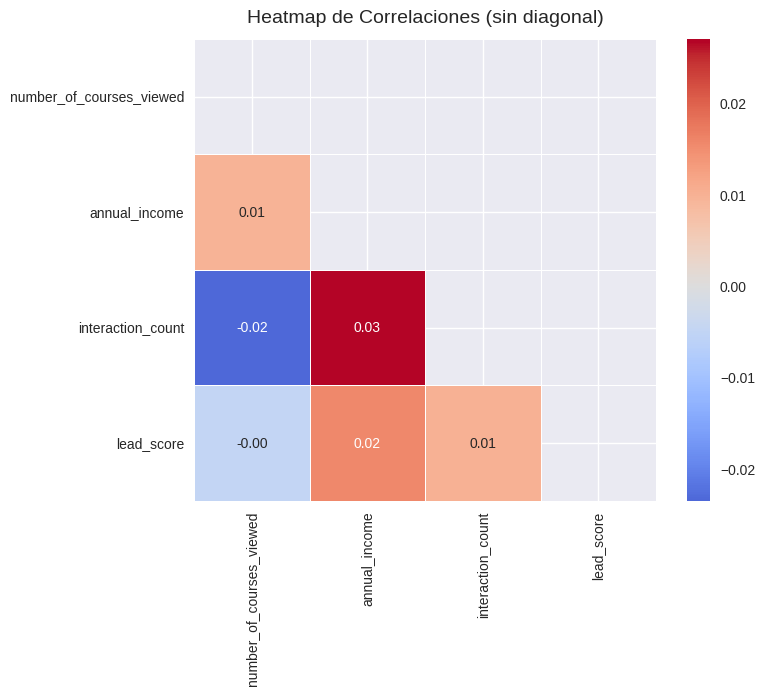

In [17]:
# Crear una máscara para ocultar la mitad superior + diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True
)
plt.title("Heatmap de Correlaciones (sin diagonal)", fontsize=14, pad=12)
plt.show()

### División de datos (Train/Val/Test)

**Instrucciones:**
- Dividir los datos en conjuntos de entrenamiento/validación/prueba con distribución 60%/20%/20%
- Usar `train_test_split` de Scikit-Learn con `seed=42`
- Asegurarse de que la variable objetivo `converted` no esté en el dataframe de features

In [18]:
# Primero dividir train (60%) vs temp (40%)
df_train_full, df_temp = train_test_split(df, test_size=0.4, random_state=42)

# Luego dividir temp en val (20%) y test (20%)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [19]:
print(f"Tamaño del conjunto de entrenamiento: {len(df_train_full)} ({len(df_train_full)/len(df)*100:.1f}%) -> shape: {df_train_full.shape}")
print(f"Tamaño del conjunto de validación: {len(df_val)} ({len(df_val)/len(df)*100:.1f}%) -> shape: {df_val.shape}")
print(f"Tamaño del conjunto de prueba: {len(df_test)} ({len(df_test)/len(df)*100:.1f}%) -> shape: {df_test.shape}")

Tamaño del conjunto de entrenamiento: 877 (60.0%) -> shape: (877, 9)
Tamaño del conjunto de validación: 292 (20.0%) -> shape: (292, 9)
Tamaño del conjunto de prueba: 293 (20.0%) -> shape: (293, 9)


In [20]:
# Separar features de la variable objetivo
y_train = df_train_full['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [21]:
# Eliminar la columna 'converted' de los dataframes
df_train_full = df_train_full.drop('converted', axis=1).reset_index(drop=True)
df_val = df_val.drop('converted', axis=1).reset_index(drop=True)
df_test = df_test.drop('converted', axis=1).reset_index(drop=True)

In [23]:
print(f"\nForma del conjunto de entrenamiento: {df_train_full.shape}")
print(f"Forma del conjunto de validación: {df_val.shape}")
print(f"Forma del conjunto de prueba: {df_test.shape}")


Forma del conjunto de entrenamiento: (877, 8)
Forma del conjunto de validación: (292, 8)
Forma del conjunto de prueba: (293, 8)


## Question 3: Mutual Information Score

**Pregunta:** Calcular el mutual information score entre `converted` y otras variables categóricas del dataset usando solo el conjunto de entrenamiento. Redondear los scores a 2 decimales usando `round(score, 2)`.

¿Cuál de estas variables tiene el mayor mutual information score?

In [24]:
# Identificar variables categóricas en el conjunto de entrenamiento
categorical_features = df_train_full.select_dtypes(include=['object']).columns.tolist()

print("Variables categóricas encontradas:")
print(categorical_features)

Variables categóricas encontradas:
['lead_source', 'industry', 'employment_status', 'location']


In [25]:
# Diccionario para guardar resultados
mi_scores = {}

# Calcular la información mutua para cada feature categórica
for col in categorical_features:
    mi_score = mutual_info_score(df_train_full[col], y_train)
    mi_scores[col] = round(mi_score, 2)

mi_scores

{'lead_source': 0.03,
 'industry': 0.02,
 'employment_status': 0.02,
 'location': 0.0}

In [26]:
# Crear un DataFrame a partir del diccionario
mi_df = pd.DataFrame(
    list(mi_scores.items()),
    columns=["Feature", "Mutual Information Score"]
).sort_values(by="Mutual Information Score", ascending=False).reset_index(drop=True)

# Mostrar el DataFrame resultante
mi_df

,Feature,Mutual Information Score
0,lead_source,0.03
1,industry,0.02
2,employment_status,0.02
3,location,0.00


### Preparar datos con one-hot encoding usando DictVectorizer

In [27]:
train_dicts = df_train_full.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [28]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [29]:
print(f"Forma de X_train después de one-hot encoding: {X_train.shape}")
print(f"Forma de X_val después de one-hot encoding: {X_val.shape}")

Forma de X_train después de one-hot encoding: (877, 31)
Forma de X_val después de one-hot encoding: (292, 31)


## Question 4: Regresión Logística

**Pregunta:** Entrenar una regresión logística incluyendo las variables categóricas usando one-hot encoding. Ajustar el modelo en el conjunto de entrenamiento con los siguientes parámetros para asegurar reproducibilidad:

```python
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
```

Calcular el accuracy en el conjunto de validación y redondearlo a 2 decimales.

¿Qué accuracy obtuviste?

In [30]:
# Entrenar el modelo de regresión logística
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

print("Modelo entrenado correctamente")

Modelo entrenado correctamente


In [31]:
# Calcular accuracy en validación
y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
accuracy

0.7431506849315068

In [32]:
accuracy_rounded = round(accuracy, 2)
print(f"Accuracy val: {accuracy_rounded}")

Accuracy val: 0.74


## Question 5: Eliminación de características

**Pregunta:** Encontrar la característica menos útil usando la técnica de eliminación de características (_feature elimination_). Entrenar un modelo usando las mismas características y parámetros que en Q4 (sin redondear). Luego excluir cada característica de este conjunto y entrenar un modelo sin ella. Registrar el accuracy para cada modelo.

Para cada característica, calcular la diferencia entre el accuracy original y el accuracy sin la característica.

¿Cuál de las siguientes características tiene la menor diferencia?


*Nota: La diferencia no tiene que ser positiva.*

In [33]:
# Obtener el accuracy original (sin redondear para precisión)
y_pred_original = model.predict(X_val)
accuracy_original = accuracy_score(y_val, y_pred_original)
accuracy_original

0.7431506849315068

In [34]:
cols_df = df_train_full.columns.tolist()
cols_df

['lead_source',
 'industry',
 'number_of_courses_viewed',
 'annual_income',
 'employment_status',
 'location',
 'interaction_count',
 'lead_score']

In [36]:
# Evaluar eliminando cada característica
features_to_test = cols_df
feature_importance = []

for feature in features_to_test:
    # Crear dataframes sin la característica
    df_train_no_feat = df_train_full.drop(feature, axis=1)
    df_val_no_feat = df_val.drop(feature, axis=1)
    
    # Preparar datos con one-hot encoding
    train_dicts_no_feat = df_train_no_feat.to_dict(orient='records')
    val_dicts_no_feat = df_val_no_feat.to_dict(orient='records')
    
    dv_no_feat = DictVectorizer(sparse=False)
    X_train_no_feat = dv_no_feat.fit_transform(train_dicts_no_feat)
    X_val_no_feat = dv_no_feat.transform(val_dicts_no_feat)
    
    # Entrenar modelo sin la característica
    model_no_feat = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_no_feat.fit(X_train_no_feat, y_train)
    
    # Calcular accuracy
    y_pred_no_feat = model_no_feat.predict(X_val_no_feat)
    accuracy_no_feat = accuracy_score(y_val, y_pred_no_feat)
    
    # Calcular la diferencia
    diff = accuracy_original - accuracy_no_feat
    
    # Guardar resultados como dict limpio
    feature_importance.append({
        'feature': feature,
        'accuracy_original': round(accuracy_original, 4),
        'accuracy_no_feat': round(accuracy_no_feat, 4),
        'diff': round(diff, 4)
    })
    
feature_importance

[{'feature': 'lead_source',
  'accuracy_original': 0.7432,
  'accuracy_no_feat': 0.7295,
  'diff': 0.0137},
 {'feature': 'industry',
  'accuracy_original': 0.7432,
  'accuracy_no_feat': 0.7432,
  'diff': 0.0},
 {'feature': 'number_of_courses_viewed',
  'accuracy_original': 0.7432,
  'accuracy_no_feat': 0.6781,
  'diff': 0.0651},
 {'feature': 'annual_income',
  'accuracy_original': 0.7432,
  'accuracy_no_feat': 0.8562,
  'diff': -0.113},
 {'feature': 'employment_status',
  'accuracy_original': 0.7432,
  'accuracy_no_feat': 0.7466,
  'diff': -0.0034},
 {'feature': 'location',
  'accuracy_original': 0.7432,
  'accuracy_no_feat': 0.7432,
  'diff': 0.0},
 {'feature': 'interaction_count',
  'accuracy_original': 0.7432,
  'accuracy_no_feat': 0.6747,
  'diff': 0.0685},
 {'feature': 'lead_score',
  'accuracy_original': 0.7432,
  'accuracy_no_feat': 0.7432,
  'diff': 0.0}]

In [39]:
# Convertir a DataFrame
feature_importance_df = pd.DataFrame(feature_importance)

# Ordenar por la diferencia (menor impacto primero)
feature_importance_df = feature_importance_df.sort_values(by='diff').reset_index(drop=True)

feature_importance_df

,feature,accuracy_original,accuracy_no_feat,diff
0,annual_income,0.7432,0.8562,-0.1130
1,employment_status,0.7432,0.7466,-0.0034
2,location,0.7432,0.7432,0.0000
3,industry,0.7432,0.7432,0.0000
4,lead_score,0.7432,0.7432,0.0000
5,lead_source,0.7432,0.7295,0.0137
6,number_of_courses_viewed,0.7432,0.6781,0.0651
7,interaction_count,0.7432,0.6747,0.0685


In [41]:
# Filtrar solo las características mencionadas
features_to_check = ['industry', 'employment_status', 'lead_score']

subset = feature_importance_df[feature_importance_df['feature'].isin(features_to_check)]

# Mostrar cuál tiene la menor diferencia (puede ser negativa)
min_diff_row = subset.loc[subset['diff'].idxmin()]

print("Características analizadas:")
display(subset)

print(f"\nLa característica con la menor diferencia es: '{min_diff_row['feature']}' (diff = {min_diff_row['diff']:.4f})")

Características analizadas:


,feature,accuracy_original,accuracy_no_feat,diff
1,employment_status,0.7432,0.7466,-0.0034
3,industry,0.7432,0.7432,0.0000
4,lead_score,0.7432,0.7432,0.0000



La característica con la menor diferencia es: 'employment_status' (diff = -0.0034)


## Question 6: Regularización

**Pregunta:** Entrenar una regresión logística regularizada probando los siguientes valores del parámetro `C`: `[0.01, 0.1, 1, 10, 100]`. Entrenar modelos usando todas las características como en Q4. Calcular el accuracy en el conjunto de validación y redondearlo a 3 decimales.

¿Cuál de estos valores de `C` conduce al mejor accuracy en el conjunto de validación?

**Opciones:**
- 0.01
- 0.1
- 1
- 10
- 100

*Nota: Si hay múltiples opciones con el mismo accuracy, seleccionar el menor valor de `C`.*

In [43]:
# Probar diferentes valores de C
c_list = [0.01, 0.1, 1, 10, 100]
c_list

[0.01, 0.1, 1, 10, 100]

In [56]:
results_train_use_c_param = []

for C in c_list:
    # Entrenar modelo con el valor de C especificado
    model_c = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model_c.fit(X_train, y_train)
    
    # Calcular accuracy en validación
    y_pred_c = model_c.predict(X_val)
    accuracy_c = accuracy_score(y_val, y_pred_c)
    accuracy_c_rounded = round(accuracy_c, 3)
    
    results_train_use_c_param.append({'C': C,
                                      'accuracy_val': accuracy_c_rounded})
    
results_train_use_c_param

[{'C': 0.01, 'accuracy_val': 0.743},
 {'C': 0.1, 'accuracy_val': 0.743},
 {'C': 1, 'accuracy_val': 0.743},
 {'C': 10, 'accuracy_val': 0.743},
 {'C': 100, 'accuracy_val': 0.743}]

In [57]:
model_use_c_param_df = pd.DataFrame(results_train_use_c_param)

feature_importance_df = model_use_c_param_df.sort_values(by='accuracy_val', ascending=False).reset_index(drop=True)

feature_importance_df

,C,accuracy_val
0,0.01,0.743
1,0.10,0.743
2,1.00,0.743
3,10.00,0.743
4,100.00,0.743


In [44]:
# Visualización de la distribución de la variable objetivo
print("\nDistribución de la variable objetivo 'converted':")
print(pd.Series(y_train).value_counts())
print(f"\nPorcentaje de conversión: {pd.Series(y_train).mean()*100:.2f}%")


Distribución de la variable objetivo 'converted':
1    535
0    342
Name: count, dtype: int64

Porcentaje de conversión: 61.00%
